In [1]:
# Fjord Circulation
import xarray as xr
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import gsw

In [2]:
Qsg = 350
hs = 4
# '/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_shelfTr/state_' + str(format(hs,'03d')) + '.nc'
# ../Model_outputs/tracer_test
File1 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_strat/state_' + str(format(hs,'03d')) + '.nc')
File2 = xr.open_dataset('/Volumes/Extreme SSD/MITgcm outputs/qf' + str(format(Qsg,'03d')) + '_strat/grid_' + str(format(hs,'03d')) + '.nc')


T0 = 1
Tn = len(File1.T)
State = File1.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40), T=range(T0,Tn))
Grid = File2.isel(X=range(120), Xp1=range(121), Y=range(30,39), Yp1=range(30,40))



x = Grid.X.data
z = Grid.Z.data
y = Grid.Y.data
CV = Grid.rA.data.mean(0) * Grid.HFacC.data.mean(1) * Grid.drF.data[:,None]  # Cell Volume
#CV1 = CV0  * Grid.drF.data



U0 = State.U.data.mean(2)
u = (U0[:,:,1:]+U0[:,:,:-1])/2
uzy = (State.U.data[:,:,:,1:]+State.U.data[:,:,:,:-1])/2


v = (State.V.data[:,:,1:,:] + State.V.data[:,:,:-1,:]) / 2
#vzy = v.mean(2)

W0 = State.W.data
bt = np.zeros((W0.shape[0],1,W0.shape[2],W0.shape[3])) # Add vertical velocity (0 m/s) at the bottom
W = np.concatenate((W0, bt), axis=1)
wzy = (W[:,1:,:,:] + W[:,:-1,:,:]) / 2
w = wzy.mean(2)


s = State.S.data # Salinity
pt = State.Temp.data # Potential temperature
pres = gsw.p_from_z(z, 55)
p = np.tile(pres,[len(x),1]).T
py = np.tile(pres,[len(y),1]).T

sxz = s.mean(2)
mask = (sxz == 0) # Exclude data covered by the sill
u[mask] = np.nan
#v[mask] = np.nan
w[mask] = np.nan

mask1 = (s == 0)
s[mask1] = np.nan
pt[mask1] = np.nan

In [3]:
#State.Yp1.data, State.Y.data
#pt.shape, z[34]

In [4]:
af_mag = np.sqrt(u**2 + w**2)

Xl, Xr = 1, 120 # X range
Zu, Zl = 0, 50 # Z range
#Zu, Zl = 15, 33 # Z range
#Zu, Zl = 32, 38 # Z range
cv = CV[Zu:Zl,Xl:Xr]

cm = np.linspace(0,.2,20) # Contour range
cs = np.linspace(1020,1040,30)
#cs1 = np.linspace(1015,1022,10)
#cs2 = np.linspace(1022,1030,20)

cmap = 'RdYlBu_r'

skipx=(slice(None,None,4))
skipz=(slice(None,None,3))

fig_path = "/Users/weiyangbao/Documents/Results_Figs/FjordCirculation/"
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

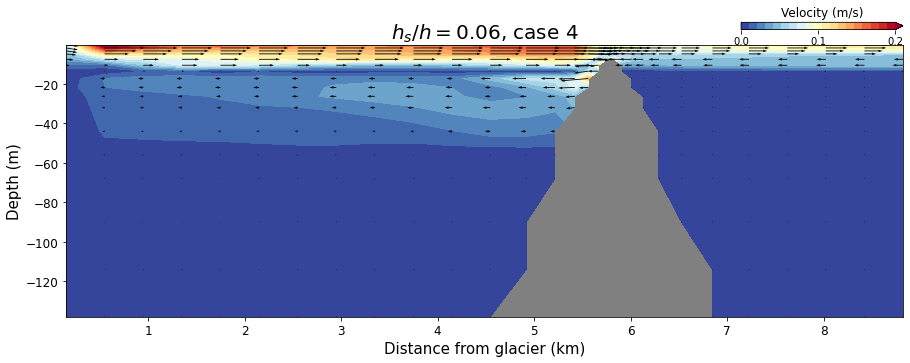

In [5]:
x_al = x[Xl:Xr] / 1000
z_al = z[Zu:Zl]
u_al = u[:,Zu:Zl,Xl:Xr]
w_al = w[:,Zu:Zl,Xl:Xr]
mag_al = af_mag[:,Zu:Zl,Xl:Xr]



for t in range(119,120):
    fig1 = plt.figure(figsize=(15,5))
    fig1.tight_layout()  
   
    rho = gsw.rho(s[t,:,:,:].mean(1), pt[t,:,:,:].mean(1), p) # Density
    rho_al = rho[Zu:Zl,Xl:Xr]
    ax1 = fig1.add_subplot(111)
    im1 = ax1.contourf(x_al[skipx], z_al[skipz], mag_al[t,skipz,skipx], cm, cmap=cmap, extend='max')
    #ax1.set_xlim([x[Xl], x[Xr-1]])
    ax1.set_facecolor('grey')
    # Set Colorbar
    cbaxes = fig1.add_axes([0.75, .923, 0.15, 0.02])
    cbar = fig1.colorbar(im1,cax=cbaxes, orientation='horizontal')
    #cbar.set_ticks([0, .04, .08, .12])
    cbar.set_ticks([0, .1, .2])
    #cbar.set_ticks([0, .03, .06])
    #cbar.set_ticks([0,  .0002, .0004])
    #cbar.set_ticks([0, .001, .002])
    cbar.ax.set_title(r'Velocity (m/s)', size=12)
    
    # Plot isohalines
    #CS1 = ax1.contour(x_al[skipx], z_al[skipz], rho_al[skipz,skipx], cs, colors='grey', linewidths=1)
    #plt.clabel(CS1, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    
    #CS1 = ax1.contour(x_al, z_al, rho_al, cs1, colors='black', linewidths=.5)
    #plt.clabel(CS1, cs1[1::2], fmt='%1.1f', fontsize=10, inline=True)


    #CS2 = ax1.contour(x_al, z_al, rho_al, cs2, colors='black', linewidths=.5)
    #plt.clabel(CS2, cs2[1::2], fmt='%1.1f', fontsize=10, inline=True)
    
    
    #ax1.axvline(x=5800, color='g',lw=2)
    ax1.set_ylabel('Depth (m)', size=15)
    ax1.set_xlabel('Distance from glacier (km)', size=15)
    ax1.tick_params(labelsize=12)
    #ax1.set_title(r'Time '+str(t), loc='center', size=20)
    #ax1.set_title(r'$h_s=$'+str(9)+' m, $h_s/h=$'+str(9/150), loc='center', size=20)
    ax1.set_title(r'$h_s/h=$'+str(9/150)+', case 4', loc='center', size=20)
    ax1.tick_params(labelsize=12)
    
    # Plot Velocity
    u_al[[1,2,3,4,6,7,8,9,11,12,14,15,17,18,19,21,23,24,26,27,29,30], :] = np.nan
    w_al[[1,2,3,4,6,7,8,9,11,12,14,15,17,18,19,21,23,24,26,27,29,30], :] = np.nan
    Q_1 = ax1.quiver(x_al[skipx],z_al[skipz],u_al[t,skipz,skipx], w_al[t,skipz,skipx],scale=4, width=0.001, color='k')
    #Q_1 = ax1.quiver(x_al[skipx],z_al[skipz],u_al[t,skipz,skipx], w_al[t,skipz,skipx]*5,scale=1, width=0.001, color='k')
    #ax1.quiverkey(Q_1, 0.87, 0.8, 0.05,r'0.05 $m/s$', fontproperties={'size' : 15}, coordinates='figure')
    

    #plt.close()
    #fig1.savefig(fig_path + '/time_r' + format(t, '03d') + '.png', dpi=150, bbox_inches='tight')

In [6]:
u_al[115,:,6]

array([ 3.0695686e-01,  2.9514360e-01,  2.8022048e-01,  2.6345640e-01,
        2.4574901e-01,  2.2790839e-01,  2.1064429e-01,  1.9448125e-01,
        1.7973678e-01,  1.6642912e-01,  1.4883620e-01,  1.3253298e-01,
        1.2857637e-01,  1.2831767e-01,  1.1185372e-01,  8.7107562e-02,
        5.6326095e-02,  2.6169702e-02, -9.1450196e-03, -2.9704992e-02,
       -3.7865821e-02, -4.1907765e-02, -4.1228116e-02, -3.7704721e-02,
       -3.6440365e-02, -3.4191333e-02, -3.2615893e-02, -3.0502463e-02,
       -2.8810810e-02, -2.7319977e-02, -2.5611956e-02, -2.0260211e-02,
       -1.6477404e-02, -1.6400121e-02, -1.6237786e-02, -1.5419357e-02,
       -1.4521448e-02, -1.3481008e-02, -1.2247919e-02, -1.1610797e-02,
       -1.0402978e-02, -8.5762059e-03, -6.6997670e-03, -4.2419685e-03,
       -2.2023751e-03,  2.9962487e-04, -1.0491355e-02, -4.7913603e-03,
        6.8211728e-03, -1.0362253e-02], dtype=float32)

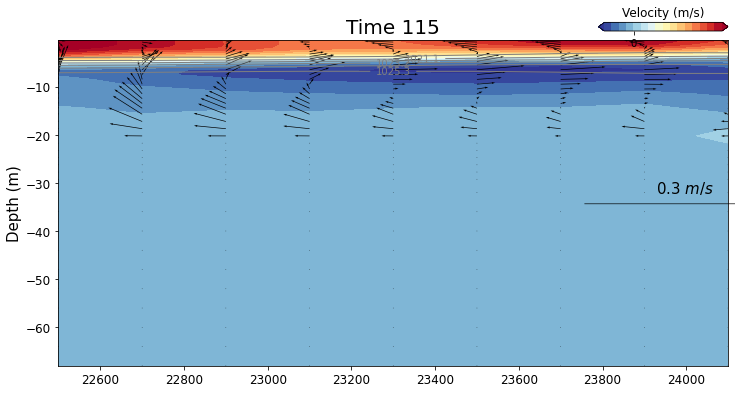

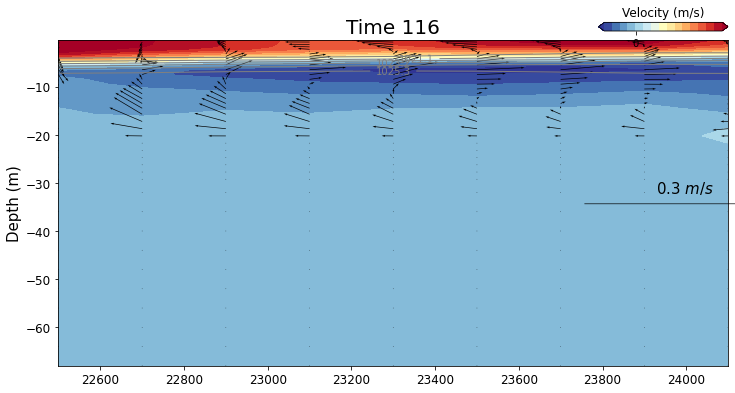

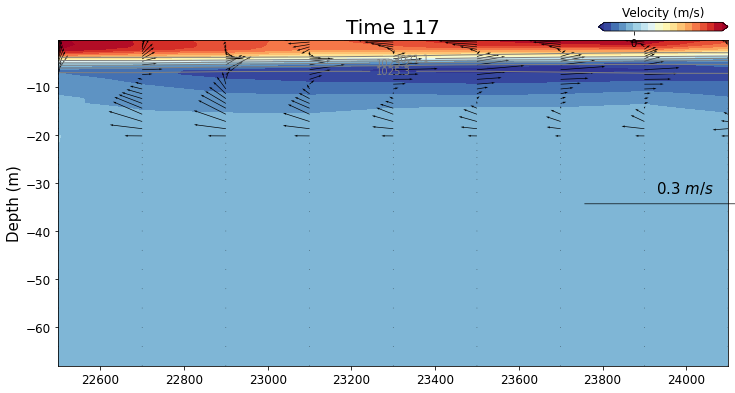

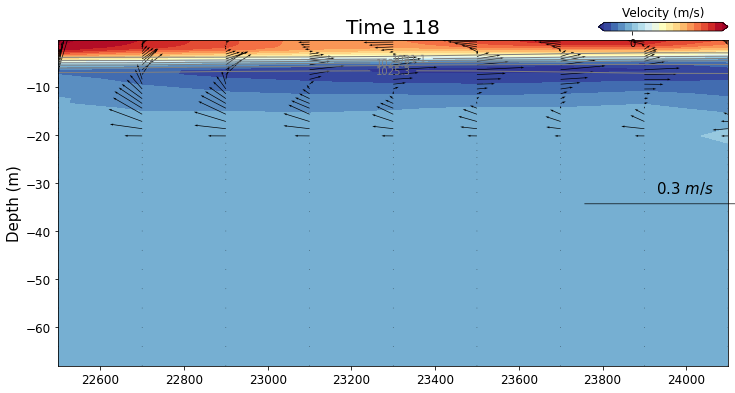

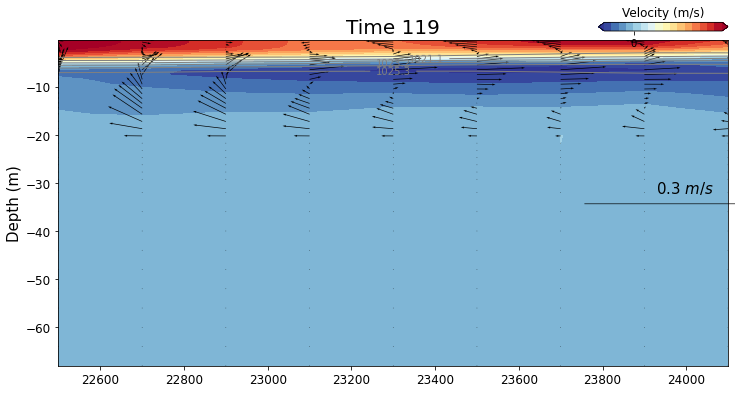

In [17]:
x_loc = 80
z_ac = z[Zu:Zl]
u_ac = uzy[:,Zu:Zl,:,x_loc]
w_ac = wzy[:,Zu:Zl,:,x_loc]
v_ac = v[:,Zu:Zl,:,x_loc]



for t in range(115,120):
    fig2 = plt.figure(figsize=(12,6))
    fig2.tight_layout()  
   
    rho = gsw.rho(s[t,:,:,x_loc], pt[t,:,:,x_loc], py) # Density
    rho_ac = rho[Zu:Zl,:]
    ax2 = fig2.add_subplot(111)
    im2 = ax2.contourf(y, z_ac, u_ac[t,:,:], 20, cmap=cmap, extend='both')
    #ax1.set_xlim([x[Xl], x[Xr-1]])
    ax2.set_facecolor('k')
    # Set Colorbar
    cbaxes = fig2.add_axes([0.75, .9, 0.15, 0.02])
    cbar = fig2.colorbar(im2,cax=cbaxes, orientation='horizontal')
    cbar.set_ticks([-5, 0, 5])
    cbar.ax.set_title(r'Velocity (m/s)', size=12)
    
    # Plot isohalines
    CS2 = ax2.contour(y, z_ac, rho_ac, cs, colors='grey', linewidths=1)
    plt.clabel(CS2, cs[1::2], fmt='%1.1f', fontsize=10, inline=True)
    #ax1.axvline(x=5800, color='g',lw=2)
    ax2.set_ylabel('Depth (m)', size=15)
    ax2.tick_params(labelsize=12)
    ax2.set_title(r'Time '+str(t), loc='center', size=20)
    ax2.tick_params(labelsize=12)
    
    # Plot Velocity
    Q_2 = ax2.quiver(y,z_ac,v_ac[t,:,:], w_ac[t,:,:]*10,scale=1, width=0.001, color='k')
    ax2.quiverkey(Q_2, 0.85, 0.5, 0.3,r'0.3 $m/s$', fontproperties={'size' : 15}, coordinates='figure')
    

    #plt.close()
    #fig1.savefig(fig_path + '/time_r' + format(t, '03d') + '.png', dpi=200, bbox_inches='tight')

In [42]:
# Generate GIF from saved output figures
import imageio
import glob

images = []
imagenames = sorted(glob.glob(fig_path + '/time_r*.png'))

for filename in imagenames:
    images.append(imageio.imread(filename))
imageio.mimsave(fig_path + 'hs009.gif', images, duration=.6)

In [7]:
fig1.savefig(fig_path + '/N2_case1_4.png', dpi=200, bbox_inches='tight')
#fig2.savefig(fig_path + '/AF_dis.png', dpi=200, bbox_inches='tight')